In [1]:
import torch

In [4]:
#Задание 1
#Вычислить градиент одной из функций ниже (для параметров, отделенных через ; градиент не нужен):
def grad1(x):
    x = x.clone()
    x.requires_grad_(True)
    
    f = torch.max(torch.abs(x))
    f.backward()
    return x.grad

In [5]:
grad1(torch.tensor([.1,1.,2.,.2]))

tensor([0., 0., 1., 0.])

In [ ]:
#Задание 5
#Постройте свёрточную нейронную сеть для классификации изображений в датасете Intel

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['intel-image-classification', 'adult-income-dataset']


In [4]:
!ls ../input

adult-income-dataset  intel-image-classification


In [5]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [6]:
import torch.utils.data as tdata

In [7]:
!ls ../input/intel-image-classification/seg_train/seg_train/
!ls ../input/intel-image-classification/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street
buildings  forest  glacier  mountain  sea  street


In [8]:
data_path_format = '../input/intel-image-classification/seg_{0}/seg_{0}'

In [9]:
np.random.seed(5315)
torch.manual_seed(9784)

In [10]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [11]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [12]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [13]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [14]:
from sklearn import model_selection

In [15]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [16]:
print(len(val_indices))

1404


In [17]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [18]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/intel-image-classification/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/intel-image-classification/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7fe704a829e8>, 'validation': <torch.uti

In [19]:
from IPython.display import display

In [20]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [21]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [22]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

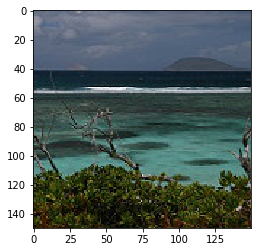

In [23]:
imshow(image_datasets['train'][8555][0]) # 5946

In [24]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [25]:
import torch.nn as F
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.c1 = nn.Conv2d(3, 50, 3)
        self.mp1 = nn.MaxPool2d(2, 2)
        self.r1 = F.ReLU()
        
        self.c2 = nn.Conv2d(50, 100, 3)
        self.r2 = F.ReLU()
        
        self.c3 = nn.Conv2d(100, 150, 3)
        self.mp3 = nn.MaxPool2d(2, 2)  
        self.r3 = F.ReLU()
        
        self.c4 = nn.Conv2d(150, 150, 3)
        self.r4 = F.ReLU()
        
        self.c5 = nn.Conv2d(150, 150, 3)
        self.mp5 = nn.MaxPool2d(2, 2)
        self.r5 = F.ReLU()
        
        self.c6 = nn.Conv2d(150, 150, 3)
        self.mp6 = nn.MaxPool2d(2, 2)
        self.r6 = F.ReLU()
        
        self.fc = nn.Linear(150*6*6, 6)
        
    def forward(self, x):
        x = self.c1(x)
        x = self.mp1(x)
        x = self.r1(x)
        
        x = self.c2(x)
        x = self.r2(x)
        
        x = self.c3(x)
        x = self.mp3(x)
        x = self.r3(x)
        
        x = self.c4(x)
        x = self.r4(x)
        
        x = self.c5(x)
        x = self.mp5(x)
        x = self.r5(x)
        
        x = self.c6(x)
        x = self.mp6(x)
        x = self.r6(x)
        
        #print(x.size(0), x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        x = self.fc(x)
        
        return x

In [26]:
ptr = MyNet()
ptr = ptr.to(device)

In [27]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [28]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [29]:
import time
start = time.time()

In [30]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.3754297559019886
Epoch 0, iteration 315 training_loss 1.114066776595538
Epoch 0, iteration 473 training_loss 1.0447598558060731
Epoch 0, iteration 631 training_loss 0.9664721130570278
Epoch 0, iteration 789 training_loss 0.9220320991700208
Epoch 0, val_loss 0.807924013923515, accuracy = 0.6965811965811965
Epoch 1, iteration 157 training_loss 0.8442203875961183
Epoch 1, iteration 315 training_loss 0.7740727063221268
Epoch 1, iteration 473 training_loss 0.7108430387098578
Epoch 1, iteration 631 training_loss 0.6785058636642709
Epoch 1, iteration 789 training_loss 0.6617887463373474
Epoch 1, val_loss 0.5908719009973786, accuracy = 0.7898860398860399
Epoch 2, iteration 157 training_loss 0.6171443447282042
Epoch 2, iteration 315 training_loss 0.5798028790498082
Epoch 2, iteration 473 training_loss 0.6036287285859072
Epoch 2, iteration 631 training_loss 0.5898030161668982
Epoch 2, iteration 789 training_loss 0.549488917228919
Epoch 2, val_loss 0.5249429

In [31]:
end = time.time()
print(end - start)

231.56352734565735


In [32]:
from torchvision.utils import make_grid

In [33]:
xx, yy = next(iter(image_dataloaders['validation']))

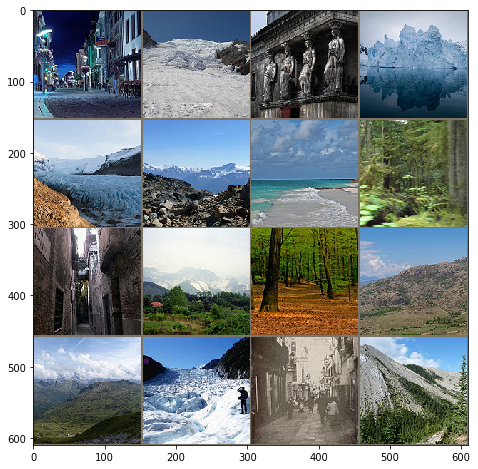

['street', 'glacier', 'street', 'glacier', 'mountain', 'mountain', 'sea', 'forest', 'buildings', 'mountain', 'forest', 'mountain', 'mountain', 'glacier', 'street', 'mountain']
['street', 'glacier', 'buildings', 'glacier', 'glacier', 'mountain', 'sea', 'forest', 'street', 'mountain', 'forest', 'mountain', 'mountain', 'glacier', 'street', 'mountain']


In [34]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [35]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [36]:
from sklearn import metrics

In [37]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [38]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.83      0.75      0.79       437
      forest       0.97      0.94      0.95       474
     glacier       0.87      0.69      0.77       553
    mountain       0.68      0.90      0.77       525
         sea       0.89      0.78      0.83       510
      street       0.79      0.89      0.84       501

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.84      0.82      0.83      3000
weighted avg       0.84      0.82      0.82      3000



In [39]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,329,3,1,17,7,80
forest,4,445,1,7,0,17
glacier,3,4,379,139,21,7
mountain,3,2,29,474,15,2
sea,17,4,26,55,397,11
street,40,2,0,7,6,446
